# TENSORBOARD로 모델, 데이터, 학습 시각화하기

목표: 네트워크가 학습되는 것을 Tensorboard를 이용하여 확인하기

1. (이전 튜토리얼과 거의 비슷하게) 데이터를 읽고 적절히 변환합니다.
2. TensorBoard를 설정(set up)합니다.
3. TensorBoard에 기록(write)합니다.
4. TensorBoard를 사용하여 모델 구조를 살펴봅니다.
5. 약간의 코드를 추가하여 TensorBoard에서 이전 튜토리얼에서 만든 시각화의 대화식(interactive) 버전을 만듭니다.
  1. 학습 데이터를 검사(inspect)하는 몇 가지 방법
  2. 학습에 따른 모델의 성능을 추적(track)하는 방법
  3. 학습이 완료된 모델의 성능을 평가(assess)하는 방법

References
1. [Tensorboard로 모델, 데이터, 학습 시각화하기](https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html)
2. [FashionMNIST 설명](https://www.tensorflow.org/datasets/catalog/fashion_mnist)

## 데이터 준비하기

Pytorch dataset에서 사용가능한 FasionMNIST 데이터 셋 이용함
* 옷에 대한 28x28 이미지와 해당하는 class를 나타낸 데이터 셋

![FashionMNIST](resources/images/fashion_mnist.png)

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# 분류 결과를 위한 상수
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 이미지를 보여주기 위한 헬퍼(helper) 함수
# (아래 `plot_classes_preds` 함수에서 사용)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 모델 구조 정의하기

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## TensorBoard 설정

이제 torch.utils 의 tensorboard 를 불러오고, TensorBoard에 정보를 제공(write)하는 SummaryWriter 를 주요한 객체인 SummaryWriter 를 정의하여 TensorBoard를 설정합니다.

In [4]:
from torch.utils.tensorboard import SummaryWriter

# 기본 `log_dir` 은 "runs"이며, 여기서는 더 구체적으로 지정하였습니다
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

## TensorBoard에 기록하기

TensorBoard에 이미지 표시(구체적으로는 make_grid 를 사용하여 그리드(grid))
* writer 객체를 이용하여 tensorboard에 데이터 기록
* `tensorboard --logdir=runs` 을 이용하면 tensorboard에서 확인이 가능
  * 여기서 logging 폴더 runs는 위에서 설정한 `runs/fashion...`의 runs임

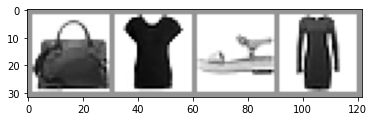

In [5]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

Tensorboard를 이용하여 모델 살펴보기

In [7]:
writer.add_graph(net, images)
writer.close()

C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## TensorBoard에 Projector 추가하기

*`add_embedding` 메소드를 이용하여 고차원 데이터의 저차원 표현 시각화

In [9]:
# 헬퍼(helper) 함수
def select_n_random(data, labels, n=100):
    '''
    데이터셋에서 n개의 임의의 데이터포인트(datapoint)와 그에 해당하는 라벨을 선택합니다
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 임의의 이미지들과 정답(target) 인덱스를 선택합니다
images, labels = select_n_random(trainset.data, trainset.targets)

# 각 이미지의 분류 라벨(class label)을 가져옵니다
class_labels = [classes[lab] for lab in labels]

# 임베딩(embedding) 내역을 기록합니다
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

## TensorBoard로 모델 학습 추적하기

이전 예제에서는 단순히 모델 학습 중 손실(running loss)을 2000번 반복할 때마다 출력 하기만 했습니다. 이제 TensorBoard에 학습 중 손실을 기록하는 것 대신에 plot_classes_preds 함수를 통해 모델의 예측 결과를 함께 볼 수 있도록 하겠습니다.

In [10]:
# 헬퍼 함수

def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다. 이는 신경망의 예측 결과 / 확률과 함께 정답을 보여주며,
    예측 결과가 맞았는지 여부에 따라 색을 다르게 표시합니다. "images_to_probs"
    함수를 사용합니다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과 / 정답과 함께 표시(plot)합니다
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

마지막으로, 이전 튜토리얼과 동일한 모델 학습 코드에서 1000 배치마다 콘솔에 출력하는 대신에 TensorBoard에 결과를 기록하도록 하여 학습을 해보겠습니다; 이는 add_scalar 함수를 사용합니다.

또한, 학습을 진행하면서 배치에 포함된 4개의 이미지에 대한 모델의 예측 결과와 정답을 비교(versus)하여 보여주는 이미지를 생성하도록 하겠습니다.

In [11]:
running_loss = 0.0
for epoch in range(1):  # 데이터셋을 여러번 반복

    for i, data in enumerate(trainloader, 0):

        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # 매 1000 미니배치마다...

            # ...학습 중 손실(running loss)을 기록하고
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
            # Matplotlib Figure를 기록합니다
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


이전 튜토리얼에서는 모델이 학습 완료된 후에 각 분류별 정확도(per-class accuracy)를 살펴봤습니다; 여기서는 TensorBoard를 사용하여 각 분류별 정밀도-재현율(precision-recall) 곡선( 여기 에 좋은 설명이 있습니다)을 그려보겠습니다

## TensorBoard로 학습된 모델 평가하기

In [13]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옵니다
# 2. 예측 결과를 test_size 텐서로 가져옵니다
# 실행하는데 10초 이하 소요
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

In [15]:
# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)